# NLP Project: Amazon Alexa Reviews Classification


In [0]:
# Import main packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

#### Import the Amazon Alexa Reviews dataset from google drive

To access data from google drive, we should first obtain an authentification. If you don't have PyDrive, you can install it with pip first. 

In [0]:
 # !pip install PyDrive

Then follow the instructions below.

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [85]:
file_id = "1ua1fTEsKDCGnGADEyDXturMeFe7soPbp"
downloaded = drive.CreateFile({'id':file_id})  
downloaded.GetContentFile('amazon_alexa.tsv')

df = pd.read_csv("amazon_alexa.tsv", sep="\t")
df["reviews"] = df["verified_reviews"]
df.head()

,rating,date,variation,verified_reviews,feedback,reviews
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,Love my Echo!
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,Loved it!
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you. I like being able to turn lights on and off while away from home.",1,"Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you. I like being able to turn lights on and off while away from home."
3,5,31-Jul-18,Charcoal Fabric,"I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well.",1,"I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well."
4,5,31-Jul-18,Charcoal Fabric,Music,1,Music


The dataset contains five columns which are ```rating```, ```date```, ```variation```, ```reviews```, ```feedback```. Each ```review``` (text) is assigned with a ```rating``` (label). Our purpose is to use the text content of reviews to predict customer ratings into one of the five classes (ratings from 1 to 5). We want to build our model which learns from training set samples and establish a prediction rule to classify new samples (test sets).



In [86]:
# Show the number of classes and number of samples in each class
print(f"Number of classes: {len(df.rating.unique())}")
df['rating'].value_counts()

Number of classes: 5


5    2286
4    455 
1    161 
3    152 
2    96  
Name: rating, dtype: int64

There are 2286 samples for the rating "5" and only 96 samples for the rating "2". 

#### Clean text and Tokenization

SpaCy is a python package which provides general-purpose pretrained models to processing natural language. Here we are using spaCy to tokenize the text, i.e. to segment it into words, punctuation and so on. Each language contains different tokens, this is done by applying rules specific to each language. For example, in English punctuation at the end of a sentence should be split off – whereas “U.K.” should remain one token. 

In [0]:
# Contraction mapping for handling apostrophe
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                       "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" } 


In [88]:
!pip install unidecode
import codecs
import unidecode
import re
import spacy

nlp = spacy.load('en')

def spacy_cleaner(text):
    try:
        decoded = unidecode.unidecode(codecs.decode(text, 'unicode_escape'))
    except:
        decoded = unidecode.unidecode(text)
    apostrophe_handled = re.sub("’", "'", decoded)
    expanded = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in apostrophe_handled.split(" ")])
    parsed = nlp(expanded)
    final_tokens = []
    for t in parsed:
        if t.is_punct or t.is_space or t.like_num or t.like_url or str(t).startswith('@'):
            pass
        else:
            if t.lemma_ == '-PRON-':
                final_tokens.append(str(t))
            else:
                sc_removed = re.sub("[^a-zA-Z]", '', str(t.lemma_))
                if len(sc_removed) > 1:
                    final_tokens.append(sc_removed)
    joined = ' '.join(final_tokens)
    spell_corrected = re.sub(r'(.)\1+', r'\1\1', joined)
    return spell_corrected

In [89]:
pd.set_option('display.max_colwidth', -1)
df.reviews[:10]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


0    Love my Echo!                                                                                                                                                                                                                                                                                                                                                                
1    Loved it!                                                                                                                                                                                                                                                                                                                                                                    
2    Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you.  I like being able to turn lights on and off while away from home.                                                          

In [90]:
df['verified_reviews'] = [spacy_cleaner(t) for t in df.reviews]
df.verified_reviews[:10]

0    love my echo                                                                                                                                                                                                                                                                                                                                        
1    love it                                                                                                                                                                                                                                                                                                                                             
2    sometimes while play game you can answer question correctly but Alexa say you get it wrong and answer the same as you I like be able to turn light on and off while away from home                                                                                                                             

A remark is that the text is cleaner but the punctuations are deleted. 

We now process word vectorization with tf-idf, term frequency–inverse document frequency based on a numerical statistic. Tf-idf turns text into a matrix presentation and is intended to reflect how important a word is to a document in a collection or corpus. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently. Compared to pretrained word embedding method like "Bert", it cannot capture the words' relationship to other words. However, td-idf doesn't need to be trained with external text and is less memory intensive. Thus tf-idf is convenient. And we build the baseline classification model with tf-idf.

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score

# Tf-idf vectorization
tfidf_vec = TfidfVectorizer(stop_words=None, max_features=10000, ngram_range=(1, 3))
lr = LogisticRegression()

def LogisticRegression_CV(nbr_splits, X, Y, pipeline, average_method):
    """Logistic classification validation"""

    kfold = StratifiedKFold(n_splits=nbr_splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for train, test in kfold.split(X, Y):
        lr_fit = pipeline.fit(X[train], Y[train])
        prediction = lr_fit.predict(X[test])
        scores = lr_fit.score(X[test],Y[test])
        
        accuracy.append(scores * 100)
        precision.append(precision_score(Y[test], prediction, average=average_method)*100)
        print('-'*70)
        print('Rating   :\t    1\t     2\t     3\t       4\t       5')
        print('precision:',precision_score(Y[test], prediction, average=None))
        recall.append(recall_score(Y[test], prediction, average=average_method)*100)
        print('recall   :',recall_score(Y[test], prediction, average=None))
        f1.append(f1_score(Y[test], prediction, average=average_method)*100)
        print('f1 score :',f1_score(Y[test], prediction, average=None))
        
    print('='*70)
    print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))

In [92]:
from sklearn.pipeline import Pipeline
original_pipeline = Pipeline([('vectorizer', tfidf_vec),('classifier', lr)])
LogisticRegression_CV(5, df.verified_reviews, df.rating, original_pipeline, 'macro')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------------------------------------------------------
Rating   :	    1	     2	     3	       4	       5
precision: [0.71428571 0.         1.         0.51428571 0.77226027]
recall   : [0.15625    0.         0.13333333 0.1978022  0.98471616]
f1 score : [0.25641026 0.         0.23529412 0.28571429 0.86564299]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------------------------------------------------------
Rating   :	    1	     2	     3	       4	       5
precision: [1.         0.         0.75       0.54545455 0.75374376]
recall   : [0.09375    0.         0.09677419 0.13186813 0.99124726]
f1 score : [0.17142857 0.         0.17142857 0.21238938 0.8563327 ]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------------------------------------------------------
Rating   :	    1	     2	     3	       4	       5
precision: [0.71428571 0.         1.         0.54545455 0.77040816]
recall   : [0.15625    0.         0.06451613 0.1978022  0.99124726]
f1 score : [0.25641026 0.         0.12121212 0.29032258 0.86698565]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------------------------------------------------------
Rating   :	    1	     2	     3	       4	       5
precision: [0.625      0.         1.         0.5483871  0.77079796]
recall   : [0.15625    0.         0.06666667 0.18681319 0.99343545]
f1 score : [0.25       0.         0.125      0.27868852 0.86806883]
----------------------------------------------------------------------
Rating   :	    1	     2	     3	       4	       5
precision: [0.75       0.         1.         0.59259259 0.75752508]
recall   : [0.09090909 0.         0.03333333 0.17582418 0.99124726]
f1 score : [0.16216216 0.         0.06451613 0.27118644 0.85876777]
accuracy: 75.49% (+/- 0.48%)
f1 score: 29.87% (+/- 2.01%)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Since there is a disproportionate ratio of observations in each class. Since our dataset is quite imbalanced and we try to handle the imbalanced classes while processing embedding. We finally choose ```RandomOverSampler``` to resample unbalanced classes since it obtains better performance than other methods we tested.

In [93]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
tfidf_vec = TfidfVectorizer(stop_words=None, max_features=100000, ngram_range=(1, 3))
tfidf_vec.fit(df.verified_reviews, df.rating)
ROS_pipeline = make_pipeline(tfidf_vec, RandomOverSampler(random_state=777),lr)
LogisticRegression_CV(5, df.verified_reviews, df.rating, ROS_pipeline, 'macro')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


----------------------------------------------------------------------
Rating   :	    1	     2	     3	       4	       5
precision: [0.65217391 0.9        0.80952381 0.54807692 0.90254237]
recall   : [0.46875    0.47368421 0.56666667 0.62637363 0.930131  ]
f1 score : [0.54545455 0.62068966 0.66666667 0.58461538 0.91612903]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


----------------------------------------------------------------------
Rating   :	    1	     2	     3	       4	       5
precision: [0.71428571 0.83333333 0.56521739 0.61728395 0.86573146]
recall   : [0.46875    0.26315789 0.41935484 0.54945055 0.9452954 ]
f1 score : [0.56603774 0.4        0.48148148 0.58139535 0.90376569]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


----------------------------------------------------------------------
Rating   :	    1	     2	     3	       4	       5
precision: [0.64285714 1.         0.61111111 0.54901961 0.8951782 ]
recall   : [0.5625     0.26315789 0.35483871 0.61538462 0.93435449]
f1 score : [0.6        0.41666667 0.44897959 0.58031088 0.9143469 ]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


----------------------------------------------------------------------
Rating   :	    1	     2	     3	       4	       5
precision: [0.67741935 0.66666667 0.69230769 0.45283019 0.87473461]
recall   : [0.65625    0.3        0.3        0.52747253 0.90153173]
f1 score : [0.66666667 0.4137931  0.41860465 0.48730964 0.88793103]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


----------------------------------------------------------------------
Rating   :	    1	     2	     3	       4	       5
precision: [0.5        0.875      0.66666667 0.54901961 0.8895966 ]
recall   : [0.51515152 0.36842105 0.33333333 0.61538462 0.91684902]
f1 score : [0.50746269 0.51851852 0.44444444 0.58031088 0.90301724]
accuracy: 81.30% (+/- 1.49%)
f1 score: 60.22% (+/- 3.28%)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


We observed that with the over sampled dataset, the logistic regression gains both in accuracy and in F1 score.

## Chapter 2: Multi-class sentiment analysis with neural networks

This chapter aims to improve the sentiment classification performance by using neural networks. Firstly, we use a simple convolutional neural network aka CNN with static word vectors.  This model will serve as a baseline for the BERT pretrained model with a transformer later.

### CNN for multi-class classification
Below, we setup the fields and load the ```CNNSentimentClassification``` model.

Randomized over-sampling for text in dataframe

In [0]:
def ROS_dataframe(dataframe: pd.DataFrame, label: str, rep_rate) -> pd.DataFrame:
    '''
    Create a dataset by resampling up the minor classes.
    Arguments:
        dataframe : Original DataFrame
        label     : Specify the column in the dataframe which contains the label of classes
    '''
    labels = dataframe[label].unique()
    # max sample number among all classes
    max_len = max(dataframe[label].value_counts())

    df_ROS = dataframe
    for l in labels:
      df_s = pd.DataFrame()
      n = dataframe[label].value_counts()[l]
      len_sample = int((max_len - n) * rep_rate)
      # Bootstrap resampling for minor classes 
      sample = np.random.randint(n, size = len_sample)
      df_s = dataframe[dataframe[label] == l].iloc[sample]
      df_ROS = pd.concat([df_ROS, df_s], ignore_index= True)
    
    return df_ROS

Transform a dataframe into dataset then feed it to torch.

In [0]:
from torchtext.data import Field, Dataset, Example

class DataFrameDataset(Dataset):
    """Class to convert pandas DataFrames into dataset that can be used for torch"""
    def __init__(self, examples, fields): #, filter_pred=None):
        '''
        Create a dataset from a pandas dataframe of examples and Fields
        Arguments:
            examples pd.DataFrame: DataFrame of examples
            fields {str: Field}  : The Fields to use in this tuple. The
                string is a field name, and the Field is the associated field.
        '''
        self.examples = examples.apply(SeriesExample.fromSeries, args=(fields,), axis=1).tolist()
        self.fields = dict(fields)
        # Unpack field tuples
        for n, f in list(self.fields.items()):
            if isinstance(n, tuple):
                self.fields.update(zip(n, f))
                del self.fields[n]

class SeriesExample(Example):
    """Class to convert a pandas Series to an Example"""

    @classmethod
    def fromSeries(cls, data, fields):
        return cls.fromdict(data.to_dict(), fields)

    @classmethod
    def fromdict(cls, data, fields):
        ex = cls()

        for key, field in fields.items():
            if key not in data:
                raise ValueError("Specified key {} was not found in "
                "the input data".format(key))
            if field is not None:
                setattr(ex, key, field.preprocess(data[key]))
            else:
                setattr(ex, key, data[key])
        return ex

#### SpaCy tokenizer

In [0]:
import spacy

# create a tokenizer function and tokenize with spaCy
spacy_en = spacy.load('en')
def tokenizer(text): 
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [0]:
#!pip install torchtext==0.2.3
from torchtext import data
from sklearn.utils import shuffle

df_ROS = ROS_dataframe(df, 'rating', 0.1)
df_ROS = shuffle(df_ROS)
indexDel = df_ROS[df_ROS.verified_reviews.transform(lambda x: len(x)<=2)].index
df_ROS.drop(indexDel, inplace=True)

# Here we separate the train and test dataset
df_train = df_ROS.iloc[:int(0.6*df_ROS.shape[0])]
df_test = df_ROS.iloc[int(0.6*df_ROS.shape[0]):int(0.8*df_ROS.shape[0])]
df_val = df_ROS.iloc[int(0.8*df_ROS.shape[0]):]
df_train = df_train.reset_index()
df_test = df_test.reset_index()
df_val = df_val.reset_index()

TEXT = data.Field(sequential=True, tokenize=tokenizer, lower=True)
LABELS = data.LabelField()
fields = { 'rating' : LABELS, 'verified_reviews' : TEXT }

train_data = DataFrameDataset(df_train, fields)
test_data = DataFrameDataset(df_test, fields)
valid_data = DataFrameDataset(df_val, fields)

#### Build the vocab and load the pre-trained word embeddings.
Next, we'll build the vocabulary. With TorchText, we build a `vocab` object which contains numerical information of the original text. The `vocab` object contains information about the importance of each word which is similar to the tf-idf vectorization. And we will load pretrained weights for word embedding. For this purpose we need to download the pretrained weights on an external database, for example `glove.6B.100d`. As this dataset is small (only ~1000 training examples) it also has a very small vocabulary.

In [0]:
MAX_VOCAB_SIZE = 500

TEXT.build_vocab(train_data, vectors="glove.6B.100d", max_size = MAX_VOCAB_SIZE, unk_init = torch.Tensor.normal_)
LABELS.build_vocab(train_data)
# vars(TEXT)

We create the iterators.

In [0]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, device = device, sort_key=lambda x: len(x.verified_reviews))

In [100]:
print(train_iterator)
next(iter(train_iterator))


[torchtext.data.batch.Batch of size 64]
	[.rating]:[torch.cuda.LongTensor of size 64 (GPU 0)]
	[.verified_reviews]:[torch.cuda.LongTensor of size 122x64 (GPU 0)]

#### Build the model
The CNN is often used for images in 2D. With text classification, we are treating sequential 1-dimentional data since text are vectorized. So we need to adapt this method into vectors. A 1x2 filter can look over a 2 sequential words in a piece of text, i.e. a bi-gram. We will use multiple filters of the same size which will look at the bi-grams (a 1x2 filter) within the text. And we no longer explicitly need to create the bi-grams and append them to the end of the sentence.

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class CNNSentimentClassification(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        text = text.permute(1, 0)
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

We define the parameters of our classification model, making sure to set ```OUTPUT_DIM``` to $C$, as $C$ the number of classes. We can get $C$ easily by using the size of the ```LABEL``` vocab, much like we used the length of the TEXT vocab to get the size of the vocabulary of the input.

In [0]:
# Checking the number of parameters:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [103]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [2,2,2]
OUTPUT_DIM = len(LABELS.vocab)
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

CNNmodel = CNNSentimentClassification(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

print(f'The model has {count_parameters(CNNmodel):,} trainable parameters')

The model has 112,005 trainable parameters


We use ```CrossEntropyLoss``` as loss function in this multi-class classification problem. ```CrossEntropyLoss``` performs a softmax function over our model outputs and the loss is given by the cross entropy between that and the label.

```CrossEntropyLoss``` is used when our examples exclusively belong to one of $C$ classes. Our model outputs a $C$ dimensional vector, where the value of each element is the beleief that the example belongs to that class.

For example, in our labels we have: [1, 2, 3, 4, 5]. If the output of our model was something like: [5.1, 0.3, 0.1, 2.1, 0.2, 0.6] this means that the model strongly believes the example belongs to class 1, a question about a human, and slightly believes the example belongs to class 4, a numerical question.

We calculate the accuracy by performing an argmax to get the index of the maximum value in the prediction for each element in the batch, and then counting how many times this equals the actual label. We then average this across the batch.

In [0]:
import torch.optim as optim

# Next, we'll load our pre-trained embeddings.
pretrained_embeddings = TEXT.vocab.vectors
CNNmodel.embedding.weight.data.copy_(pretrained_embeddings)

# then zero the initial weights of the unknown and padding tokens.
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
CNNmodel.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
CNNmodel.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# Choose the optimizer
optimizer = optim.Adam(CNNmodel.parameters())

# Choose the loss function
criterion = nn.CrossEntropyLoss()

CNNmodel = CNNmodel.to(device)
criterion = criterion.to(device)

In [0]:
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / torch.FloatTensor([y.shape[0]])

In [0]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [0]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.verified_reviews)
        
        loss = criterion(predictions, batch.rating)
        
        acc = categorical_accuracy(predictions, batch.rating)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss/len(iterator), epoch_acc/len(iterator)

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.verified_reviews)

            loss = criterion(predictions, batch.rating)
            
            acc = categorical_accuracy(predictions, batch.rating)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [108]:
N_EPOCHS = 30

best_valid_loss = float('inf')

train_acc_vect = []
valid_acc_vect = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(CNNmodel, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(CNNmodel, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(CNNmodel.state_dict(), 'tut5-model.pt')

    train_acc_vect.append(train_acc)
    valid_acc_vect.append(valid_acc)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% ')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% ')


Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 1.268 | Train Acc: 55.67% 
	 Val. Loss: 1.114 |  Val. Acc: 59.29% 
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 1.078 | Train Acc: 59.50% 
	 Val. Loss: 0.988 |  Val. Acc: 61.50% 
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.943 | Train Acc: 63.46% 
	 Val. Loss: 0.904 |  Val. Acc: 66.73% 
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.858 | Train Acc: 67.89% 
	 Val. Loss: 0.834 |  Val. Acc: 70.52% 
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.767 | Train Acc: 71.32% 
	 Val. Loss: 0.789 |  Val. Acc: 73.25% 
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.715 | Train Acc: 73.64% 
	 Val. Loss: 0.736 |  Val. Acc: 74.16% 
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.656 | Train Acc: 77.08% 
	 Val. Loss: 0.704 |  Val. Acc: 74.04% 
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.611 | Train Acc: 79.56% 
	 Val. Loss: 0.648 |  Val. Acc: 79.25% 
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.564 | Train Acc: 80.55% 
	 Val. Loss: 0.626 |  Val. Acc: 80.30% 
Epoch: 10 

In [109]:
CNNmodel.load_state_dict(torch.load('tut5-model.pt'))

test_loss, test_acc = evaluate(CNNmodel, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% ')

Test Loss: 0.473 | Test Acc: 86.42% 


In [0]:
def predict_class(model, sentence, min_len = 4):
    model.eval()
    tokenized = [tok.text for tok in spacy_en.tokenizer(sentence)]
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    preds = model(tensor)
    max_preds = preds.argmax(dim = 1)
    return max_preds.item()

In [111]:
pred_class = predict_class(CNNmodel, "It does not work!")
print(f'Predicted class is: {LABELS.vocab.itos[pred_class]}')

Predicted class is: 1


In [112]:
pred_class = predict_class(CNNmodel, "I love the product!")
print(f'Predicted class is: {LABELS.vocab.itos[pred_class]}')

Predicted class is: 5


Everything looks fine if we try to predict rating 1 or 5.

In [113]:
pred_class = predict_class(CNNmodel, "I don't really like it.")
print(f'Predicted class is: {LABELS.vocab.itos[pred_class]}')

Predicted class is: 5


However, there seems to be a big confusion when we trying to classify a neutral remark.

### Multi-class sentiment analysis with transformers. 

In this section we try to integrating transformers into the neutral network. We are going to use the transformers library to get pre-trained models and use them as our embedding layers. 

#### Preparing Data
As seen during the lectures, tokenization is a model specific stage, thus for the BertModel we are going to use the BertTokenizer.

The transformer has already been trained with a specific vocabulary, which means we need to train with the exact same vocabulary and also tokenize our data in the same way that the transformer did when it was initially trained.

Luckily, the transformers library has tokenizers for each of the transformer models provided. In this case we are using the BERT tokenizer. The BERT tokenizer ignores casing (i.e. will lower case every word). We get this by loading the pre-trained tokenizer for example ```bert-base-uncased```, and ```bert-base-multilingual-uncased```.

In [114]:
!pip install transformers
from transformers import BertModel, BertTokenizer

In [115]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
print('The BERT model contains {} tokens.'.format(len(tokenizer.vocab)))

The BERT model contains 30522 tokens.


In [116]:
# Get tokens for our example
tokens = tokenizer.tokenize(df.reviews[0])
print(tokens)
# Index tokens
indexes = tokenizer.convert_tokens_to_ids(tokens)
print(indexes)


['love', 'my', 'echo', '!']
[2293, 2026, 9052, 999]


The transformer was trained with special tokens to mark the beginning and the end of sentences, etc. We can get these special tokens from the tokenizer and we should set the beginning of sequence and end of sequence attributes(bos_token and eos_token).


In [117]:
init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

101 102 0 100


The BERT model was trained on sequences with a defined maximum length - it does not know how to handle sequences longer than it has been trained on. 

In [118]:
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']

print(max_input_length)

512


We now need to define a function that we will pass to different data field (separate text and lable into different tensors). And it can also handle the tokenization and cut down the number of tokens to a maximum length. Note that our maximum length is 2 less than the actual maximum length. This is because we need to append two tokens to each sequence, one to the start and one to the end.

In [0]:
def tokenize_and_cut(sentence, tokenizer, maxlen):
    #Preprocessing the text to be suitable for BERT
    tokens = tokenizer.tokenize(sentence) #Tokenize the sentence
    if tokenizer.cls_token is None:
        bos_token = tokenizer.bos_token
    else:
        bos_token = tokenizer.cls_token
      
    if tokenizer.sep_token is None:
        eos_token = tokenizer.eos_token
    else:
        eos_token = tokenizer.sep_token

    if len(tokens) < maxlen:
        tokens = tokens + [tokenizer.pad_token for _ in range(maxlen - len(tokens))] #Padding sentences
    else:
        tokens = tokens[:maxlen-1] + [eos_token] #Prunning the list to be of specified max length
    return tokens
        

In [0]:
from torch.utils.data import Dataset
from transformers import AutoTokenizer

class SSTDataset(Dataset):
    '''
    Dataset for sentiment analysis
    '''
    def __init__(self, data, maxlen, model_name='bert-base-uncased'):

        #Store the contents of the file in a pandas dataframe
        self.df = data

        #Initialize the BERT tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        self.maxlen = maxlen

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        #Selecting the sentence and label at the specified index in the data frame
        sentence = self.df.loc[index, 'reviews']
        label = self.df.loc[index, 'rating']

        #Preprocessing the text to be suitable for BERT
        tokens = tokenize_and_cut(sentence, self.tokenizer, self.maxlen) #Tokenize the sentence and cut 

        tokens_ids = self.tokenizer.convert_tokens_to_ids(tokens) #Obtaining the indices of the tokens in the BERT Vocabulary
        tokens_ids_tensor = torch.tensor(tokens_ids) #Converting the list to a pytorch tensor
        #Obtaining the attention mask i.e a tensor containing 1s for no padded tokens and 0s for padded ones
        attn_mask = (tokens_ids_tensor != 0).long()

        return tokens_ids_tensor, attn_mask, label
      

In [0]:
# Data were ranged in time order. So we shuffle the dataset.
from sklearn.utils import shuffle

df = shuffle(df)

df_train = df.iloc[:int(0.6*df.shape[0])]
df_test = df.iloc[int(0.6*df.shape[0]):int(0.8*df.shape[0])]
df_val = df.iloc[int(0.8*df.shape[0]):]

df_train = df_train.reset_index()
df_test = df_test.reset_index()
df_val = df_val.reset_index()
train_set = SSTDataset(data = df_train, maxlen = 200, model_name='bert-base-uncased')
test_set = SSTDataset(data = df_test, maxlen = 200, model_name='bert-base-uncased')
val_set = SSTDataset(data = df_val, maxlen = 200, model_name='bert-base-uncased')


In [0]:
df_ROS = shuffle(df_ROS)
df_train_ROS = df_ROS.iloc[:int(0.6*df_ROS.shape[0])]
df_test_ROS = df_ROS.iloc[int(0.6*df_ROS.shape[0]):int(0.8*df_ROS.shape[0])]
df_val_ROS = df_ROS.iloc[int(0.8*df_ROS.shape[0]):]

df_train_ROS = df_train_ROS.reset_index()
df_test_ROS = df_test_ROS.reset_index()
df_val_ROS = df_val_ROS.reset_index()
train_set_ROS = SSTDataset(data = df_train_ROS, maxlen = 200, model_name='bert-base-uncased')
test_set_ROS = SSTDataset(data = df_test_ROS, maxlen = 200, model_name='bert-base-uncased')
val_set_ROS = SSTDataset(data = df_val_ROS, maxlen = 200, model_name='bert-base-uncased')


In [135]:
from torch.utils.data import DataLoader

#Creating intsances of training and validation dataloaders
train_loader = DataLoader(train_set, batch_size = 32, num_workers = 5)
test_loader = DataLoader(test_set, batch_size = 32, num_workers = 5)
val_loader = DataLoader(val_set, batch_size = 32, num_workers = 5)
print(len(train_loader))
train_loader_ROS = DataLoader(train_set_ROS, batch_size = 32, num_workers = 5)
test_loader_ROS = DataLoader(test_set_ROS, batch_size = 32, num_workers = 5)
val_loader_ROS = DataLoader(val_set_ROS, batch_size = 32, num_workers = 5)
print(len(train_loader_ROS))

60
72


In [124]:
# get the number of sentences
print(train_set.__len__(), "number of sentences in training set")
print(test_set.__len__(), "number of sentences in test set")
print(val_set.__len__(), "number of sentences in validation set")



1890 number of sentences in training set
630 number of sentences in test set
630 number of sentences in validation set


### Build the Model

Now we'll load the pre-trained model, making sure to load the same model (BERT, RoBERTa, etc) as we did for the tokenizer.

1.   `BertSentimentClassification` 
Bert Model transformer with a sequence classification head on top (a linear layer on top of the pooled output) e.g. for GLUE tasks. 
2.   `BertGRUSentimentClassification` The transformers will be fed into a GRU to produce a prediction for the sentiment of the input sentence. We get the embedding dimension size (ie. `hidden_size`) from the transformer via its config attribute. The rest of the initialization is standard.


In [0]:
import torch.nn as nn
from transformers import AutoModel

class BertSentimentClassification(nn.Module):

    def __init__(self, pretrained_model_name='bert-base-uncased', num_labels = 2):
        super(BertSentimentClassification, self).__init__()
        
        #Loading Mask Language Model 
        self.num_labels = num_labels
        self.encoder = AutoModel.from_pretrained(pretrained_model_name)

        #we append an extra layer for Classification (it will be randomly initialized)
        self.dropout = nn.Dropout(self.encoder.config.hidden_dropout_prob)
        self.classifier = nn.Linear(self.encoder.pooler.dense.out_features, num_labels)
        
        
    def forward(self, seq, attn_mask=None, labels=None):
        '''
        Inputs:
            -seq : Tensor of shape [B, T] containing token ids of sequences
            -attn_mask : Tensor of shape [B, T] containing attention masks to be used to avoid contibution of PAD tokens
        '''
        #Feeding the input to BERT model to obtain contextualized representations
        _, pooled_output = self.encoder(seq, attn_mask)
        pooled_output = self.dropout(pooled_output)

        logits = self.classifier(pooled_output)

        return logits


#### Train the `BertSentimentClassification` Model

First we train the model with train dataloader.
Then we evaluate it with the test dataset.

In [126]:
#BertForSequenceClassification model

bertmodel = BertSentimentClassification('bert-base-uncased', num_labels = 5)
bertmodel = bertmodel.to(device)
# if gpu mode
# to check if the weights of the model are in gpu : 
print(bertmodel.classifier.weight.is_cuda)
# can checkout all the layers by running model

input_ids = train_set.__getitem__(5)[0].unsqueeze(0)  # Batch size 1
attn_mask = train_set.__getitem__(5)[1].unsqueeze(0)
labels = train_set.__getitem__(5)[2]  # Batch size 1
#print(train_set.__getitem__(5))

True


In [0]:
import time
def epoch_time(start_time, end_time):
    '''
    Record the time of training
    '''
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [0]:
def classification_accuracy(preds_label, y):
    '''
    Returns accuracy per batch
    '''
    correct = (preds_label == y).float()
    acc = correct.sum() / len(correct)
    return acc

def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / torch.FloatTensor([y.shape[0]])

from sklearn.metrics import f1_score
def categorical_f1(preds_label:torch.Tensor, y:torch.Tensor, avg = 'macro'):
    preds_arr = preds_label.cpu().numpy()
    y_arr = y.cpu().numpy()
    return f1_score(y_arr, preds_arr, average = avg)


The training loop function

In [0]:
def train_iter(model, train_loader, optimizer, loss_function, gpu=False, print_every=1):
    '''
    Train the model
    '''
    loss_train, accuracy_train, f1_score_train = [],[],[]

    model.train()

    for it, (seq, attn_masks, labels) in enumerate(train_loader):
    
        #Clear gradients
        optimizer.zero_grad()  

        #Converting these to cuda tensors
        if gpu:
            seq, attn_masks, labels = seq.cuda(), attn_masks.cuda(), labels.cuda()

        #Computing loss
        out = model(seq, attn_masks)
        loss = loss_function(out, labels-1)
                        
        #Backpropagating the gradients
        loss.backward()

        #Prediction of labels
        labels_hat = torch.argmax(out, dim=1) + 1 # max_preds = preds.argmax(dim = 1, keepdim = True)

        #Score
        acc = categorical_accuracy(out, labels-1)
        f1 = categorical_f1(labels, labels_hat, avg = 'macro')

        #Optimization step
        optimizer.step()

        #Print part of the results
        if (it + 1) % print_every == 0:
            print("Iteration {} complete. Loss: {}, Accuracy: {}, F1 Score: {}.".format(it+1, loss.item(), acc.item(), f1)) 
        if it>1000:
            break

        loss_train.append(loss.item())
        accuracy_train.append(acc.item())
        f1_score_train.append(f1) 

    return loss_train, accuracy_train, f1_score_train

In [0]:
def evaluate_iter(model, test_loader, optimizer, loss_function, gpu=False):
    '''
    Validation with the test dataset
    '''
    loss_test, accuracy_test, f1_score_test = [],[],[]

    model.eval()

    with torch.no_grad():
        
        for it, (seq, attn_masks, labels) in enumerate(test_loader):
            
            #Converting these to cuda tensors
            if gpu:
                seq, attn_masks, labels = seq.cuda(), attn_masks.cuda(), labels.cuda()

            #Computing loss
            out = model(seq,attn_masks)
            loss = loss_function(out, labels-1)

            #Prediction of labels
            labels_hat = torch.argmax(out, dim=1) + 1 

            #Score
            acc = categorical_accuracy(out, labels-1)
            f1 = categorical_f1(labels, labels_hat, avg = 'macro')
        
            loss_test.append(loss.item())
            accuracy_test.append(acc.item())
            f1_score_test.append(f1) 

    #return loss_test / len(test_loader), accuracy_test / len(test_loader), f1_score_test / len(train_loader)
    return loss_test, accuracy_test, f1_score_test

In [0]:
import matplotlib.pyplot as plt

def plot_learning_curve(max_eps, accuracy_train, f1_score_train, accuracy_test, f1_score_test, title):
    """
    Generate plots: the test and training learning curve.

    """
    _, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].set_title(title + 'Accuracy')
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Score")

    accuracy_train_mean = np.mean(accuracy_train, axis=1)
    accuracy_train_std = np.std(accuracy_train, axis=1)
    accuracy_test_mean = np.mean(accuracy_test, axis=1)
    accuracy_test_std = np.std(accuracy_test, axis=1)

    X = np.arange(1,len(accuracy_train) +1)

    # Plot n_epoch vs accuracy
    axes[0].grid()
    axes[0].fill_between(X, accuracy_train_mean - accuracy_train_std,
                         accuracy_train_mean + accuracy_train_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(X, accuracy_test_mean - accuracy_train_std,
                         accuracy_test_mean + accuracy_train_std, alpha=0.1,
                         color="g")
    axes[0].plot(X, accuracy_train_mean, 'o-', color="r",
                 label="Training Accuracy")
    axes[0].plot(X, accuracy_test_mean, 'o-', color="g",
                 label="Test Accuracy")
    axes[0].legend(loc="best")

    f1_score_train_mean = np.mean(f1_score_train, axis=1)
    f1_score_train_std = np.std(f1_score_train, axis=1)
    f1_score_test_mean = np.mean(f1_score_test, axis=1)
    f1_score_test_std = np.std(f1_score_test, axis=1)

    # Plot n_epoch vs f1_score
    axes[1].grid()
    axes[1].fill_between(X, f1_score_train_mean - f1_score_train_std,
                         f1_score_train_mean + f1_score_train_std, alpha=0.1,
                         color="r")
    axes[1].fill_between(X, f1_score_test_mean - f1_score_test_std,
                         f1_score_test_mean + f1_score_test_std, alpha=0.1,
                         color="g")
    axes[1].plot(X, f1_score_train_mean, 'o-', color="r",
                 label="Training F1 Score")
    axes[1].plot(X, f1_score_test_mean, 'o-', color="g",
                 label="Test F1 Scor")
    axes[1].legend(loc="best")
    axes[1].set_title(title + 'F1 Score')
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Score")

    return plt


In [0]:
import pdb

def train_loop(model, optimizer, loss_function, train_loader, test_loader, max_eps=1, gpu=False, print_every=100, validate_every=1):
    
    if gpu:
        model = model.to("cuda")
        
    best_valid_loss = float('inf')

    loss_train, accuracy_train, f1_score_train = [],[],[]
    loss_test, accuracy_test, f1_score_test = [],[],[]

    for ep in range(max_eps):

        start_time = time.time()

        loss_train_tmp, accuracy_train_tmp, f1_score_train_tmp = train_iter(model, train_loader, optimizer, loss_function, gpu, print_every)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f'==>Epoch: {ep+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\t Train Loss: {np.mean(loss_train_tmp) :.3f} | Train Acc: {np.mean(accuracy_train_tmp)*100:.2f}% | Train f1 score: {np.mean(f1_score_train_tmp)*100:.2f}%')
        accuracy_train.append(accuracy_train_tmp)
        f1_score_train.append(f1_score_train_tmp)
        
        # Evaluate the trained model with the test dataset
        if ep % validate_every==0:

            loss_test_tmp, accuracy_test_tmp, f1_score_test_tmp= evaluate_iter(model, test_loader, optimizer, loss_function, gpu)
        
            if np.mean(loss_test_tmp) < best_valid_loss:
                best_valid_loss = np.mean(loss_test_tmp)
                torch.save(model.state_dict(), 'bert-amazon-model.pt')

            accuracy_test.append(accuracy_test_tmp)
            f1_score_test.append(f1_score_test_tmp)
            
        print(f'\t Test  Loss: {np.mean(loss_test_tmp):.3f} | Test  Acc: {np.mean(accuracy_test_tmp)*100:.2f}% | Test  f1 score: {np.mean(f1_score_test_tmp)*100:.2f}%')
    
    plot_learning_curve(max_eps, accuracy_train, f1_score_train, accuracy_test, f1_score_test, 'Bert Model Classification')

    plt.show()
        

==>Epoch: 01 | Epoch Time: 0m 36s
	 Train Loss: 1.010 | Train Acc: 69.64% | Train f1 score: 21.41%
	 Test  Loss: 0.964 | Test  Acc: 71.78% | Test  f1 score: 20.53%
==>Epoch: 02 | Epoch Time: 0m 36s
	 Train Loss: 0.928 | Train Acc: 73.70% | Train f1 score: 22.25%
	 Test  Loss: 0.967 | Test  Acc: 71.78% | Test  f1 score: 20.53%
==>Epoch: 03 | Epoch Time: 0m 36s
	 Train Loss: 0.921 | Train Acc: 73.70% | Train f1 score: 22.25%
	 Test  Loss: 0.979 | Test  Acc: 71.78% | Test  f1 score: 20.53%
==>Epoch: 04 | Epoch Time: 0m 36s
	 Train Loss: 0.916 | Train Acc: 73.70% | Train f1 score: 22.25%
	 Test  Loss: 0.960 | Test  Acc: 71.78% | Test  f1 score: 20.53%
==>Epoch: 05 | Epoch Time: 0m 36s
	 Train Loss: 0.917 | Train Acc: 73.70% | Train f1 score: 22.25%
	 Test  Loss: 0.956 | Test  Acc: 71.78% | Test  f1 score: 20.53%
==>Epoch: 06 | Epoch Time: 0m 36s
	 Train Loss: 0.915 | Train Acc: 73.70% | Train f1 score: 22.25%
	 Test  Loss: 0.955 | Test  Acc: 71.78% | Test  f1 score: 20.53%
==>Epoch: 07 | E

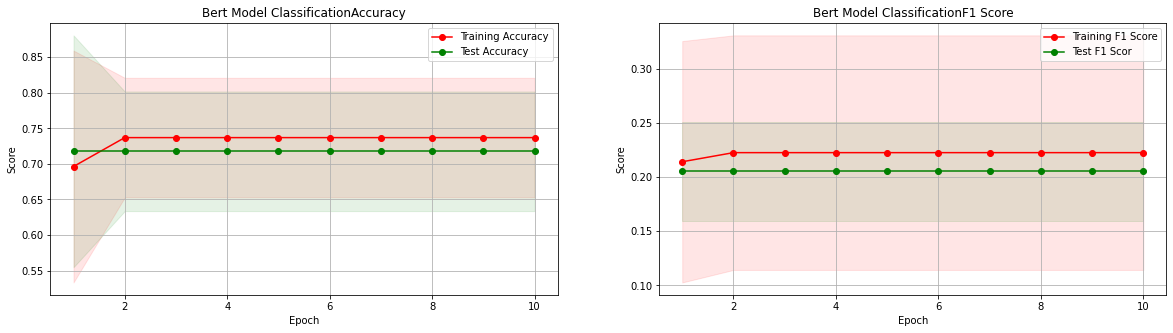

In [133]:
import torch.nn as nn
import torch.optim as optim

loss_function = nn.CrossEntropyLoss()
loss_function.to(device)
optimizer = optim.AdamW(bertmodel.parameters())
n_epochs = 10
train_loop(bertmodel, optimizer, loss_function, train_loader, test_loader, max_eps= n_epochs, print_every=100, gpu=(device.type == 'cuda'))


Train loop with random over-sampled dataset 

==>Epoch: 01 | Epoch Time: 0m 43s
	 Train Loss: 1.255 | Train Acc: 58.45% | Train f1 score: 15.49%
	 Test  Loss: 1.301 | Test  Acc: 56.02% | Test  f1 score: 14.78%
==>Epoch: 02 | Epoch Time: 0m 43s
	 Train Loss: 1.250 | Train Acc: 58.45% | Train f1 score: 15.49%
	 Test  Loss: 1.289 | Test  Acc: 56.02% | Test  f1 score: 14.78%
==>Epoch: 03 | Epoch Time: 0m 43s
	 Train Loss: 1.249 | Train Acc: 58.45% | Train f1 score: 15.49%
	 Test  Loss: 1.279 | Test  Acc: 56.02% | Test  f1 score: 14.78%
==>Epoch: 04 | Epoch Time: 0m 43s
	 Train Loss: 1.243 | Train Acc: 58.45% | Train f1 score: 15.49%
	 Test  Loss: 1.279 | Test  Acc: 56.02% | Test  f1 score: 14.78%
==>Epoch: 05 | Epoch Time: 0m 43s
	 Train Loss: 1.246 | Train Acc: 58.45% | Train f1 score: 15.49%
	 Test  Loss: 1.280 | Test  Acc: 56.02% | Test  f1 score: 14.78%
==>Epoch: 06 | Epoch Time: 0m 43s
	 Train Loss: 1.243 | Train Acc: 58.45% | Train f1 score: 15.49%
	 Test  Loss: 1.280 | Test  Acc: 56.02% | Test  f1 score: 14.78%
==>Epoch: 07 | E

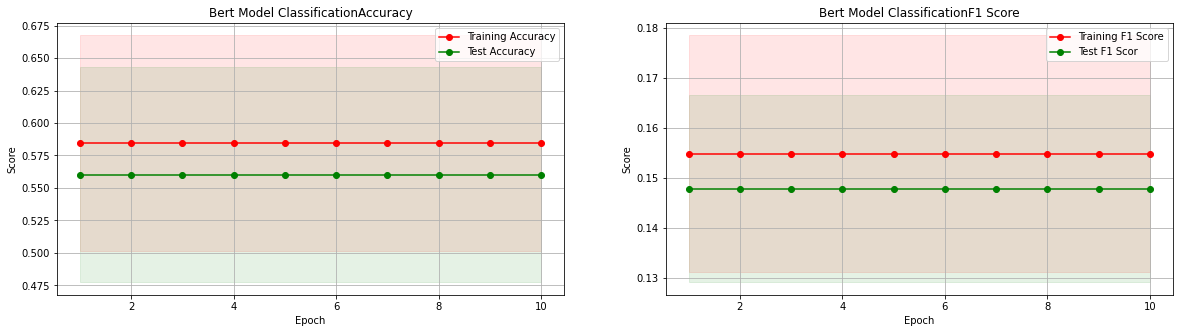

In [136]:
train_loop(bertmodel, optimizer, loss_function, train_loader_ROS, test_loader_ROS, max_eps= n_epochs, print_every=100, gpu=(device.type == 'cuda'))


==>Epoch: 01 | Epoch Time: 0m 36s
	 Train Loss: 1.611 | Train Acc: 12.92% | Train f1 score: 9.20%
	 Test  Loss: 1.594 | Test  Acc: 5.47% | Test  f1 score: 2.91%
==>Epoch: 02 | Epoch Time: 0m 36s
	 Train Loss: 1.608 | Train Acc: 13.33% | Train f1 score: 9.95%
	 Test  Loss: 1.594 | Test  Acc: 5.47% | Test  f1 score: 2.91%
==>Epoch: 03 | Epoch Time: 0m 36s
	 Train Loss: 1.611 | Train Acc: 12.71% | Train f1 score: 8.91%
	 Test  Loss: 1.594 | Test  Acc: 5.47% | Test  f1 score: 2.91%
==>Epoch: 04 | Epoch Time: 0m 36s
	 Train Loss: 1.606 | Train Acc: 14.69% | Train f1 score: 10.47%
	 Test  Loss: 1.594 | Test  Acc: 5.47% | Test  f1 score: 2.91%
==>Epoch: 05 | Epoch Time: 0m 36s
	 Train Loss: 1.613 | Train Acc: 12.81% | Train f1 score: 8.26%
	 Test  Loss: 1.594 | Test  Acc: 5.47% | Test  f1 score: 2.91%


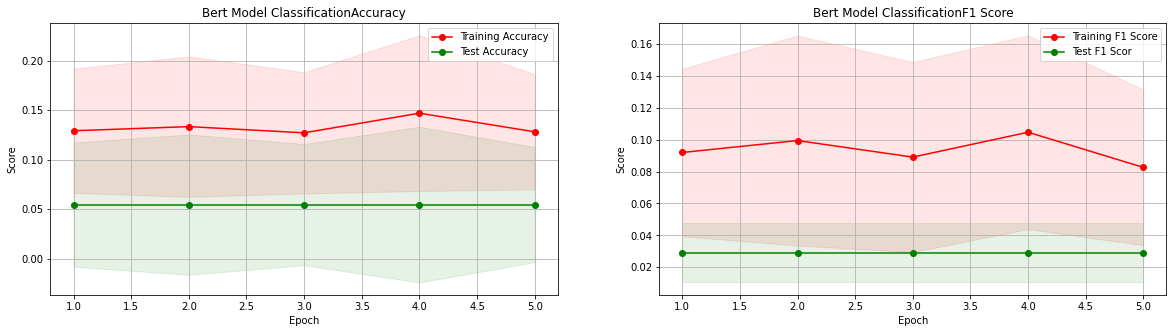

In [138]:
# Another pre-trained model
bertmultilingualmodel = BertSentimentClassification('bert-base-multilingual-uncased', num_labels = 5)
bertmultilingualmodel = bertmultilingualmodel.to(device)
n_epochs = 5
train_loop(bertmultilingualmodel, optimizer, loss_function, train_loader, test_loader, max_eps= n_epochs, print_every=100, gpu=(device.type == 'cuda'))


Next, we'll define our `BertGRUSentimentClassification` model.

Instead of using an embedding layer to get embeddings for our text, we'll be using the pre-trained transformer model. These embeddings will then be fed into a GRU to produce a prediction for the sentiment of the input sentence. We get the embedding dimension size (the ```hidden_size```) from the transformer via its config attribute. 

Within the forward pass, we wrap the transformer in a ```no_grad``` to ensure no gradients are calculated over this part of the model. The transformer actually returns the embeddings for the whole sequence as well as a pooled output. The rest of the forward pass is the standard implementation of a recurrent model, where we take the hidden state over the final time-step, and pass it through a linear layer to get our predictions.

In [0]:
import torch.nn as nn
from transformers import AutoModel

class BertGRUSentimentClassification(nn.Module):
    def __init__(self, pretrained_model_name='bert-base-uncased', hidden_dim = 128, output_dim = 1, n_layers = 2, bidirectional = True, dropout = 0.25):
        
        super().__init__()
        
        # Loading the pretrained Bert model
        self.bert = AutoModel.from_pretrained(pretrained_model_name)
        
        embedding_dim = self.bert.config.to_dict()['hidden_size']
        
        self.rnn = nn.GRU(embedding_dim, hidden_dim,
                  num_layers = n_layers,
                  bidirectional = bidirectional,
                  batch_first = True,
                  dropout = 0 if n_layers < 2 else dropout)
        
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, seq, attn_masks = None):
        
        #seq = [batch size, sent len]
                
        with torch.no_grad():
            embedded = self.bert(seq, attn_masks)[0]
                
        #embedded = [batch size, sent len, emb dim]
        
        _, hidden = self.rnn(embedded)
        
        #hidden = [n layers * n directions, batch size, emb dim]
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
                        
        output = self.out(hidden)
                
        return output

Next, we create an instance of our model using standard hyperparameters.

In [0]:
hidden_dim = 256
output_dim = 5
n_layers = 2
bidirectional = True
dropout = 0.25

bertGRUmodel = BertGRUSentimentClassification('bert-base-uncased', hidden_dim, output_dim, n_layers, bidirectional, dropout)

In [141]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Number of trainable parameters: {count_parameters(bertGRUmodel):,} ')

Number of trainable parameters: 112,243,461 


In order to freeze paramers (not train them) we need to set their requires_grad attribute to False. To do this, we simply loop through all of the named_parameters in our model and if they're a part of the bert transformer model, we set requires_grad = False. We can double check the names of the trainable parameters, ensuring they make sense. As we can see, they are all the parameters of the GRU (rnn) and the linear layer (out).

In [142]:
for name, param in bertGRUmodel.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False
    else:
        print(name)

rnn.weight_ih_l0
rnn.weight_hh_l0
rnn.bias_ih_l0
rnn.bias_hh_l0
rnn.weight_ih_l0_reverse
rnn.weight_hh_l0_reverse
rnn.bias_ih_l0_reverse
rnn.bias_hh_l0_reverse
rnn.weight_ih_l1
rnn.weight_hh_l1
rnn.bias_ih_l1
rnn.bias_hh_l1
rnn.weight_ih_l1_reverse
rnn.weight_hh_l1_reverse
rnn.bias_ih_l1_reverse
rnn.bias_hh_l1_reverse
out.weight
out.bias


Now the number of parameters reduce to under 3M.

In [143]:
print(f'The model has {count_parameters(bertGRUmodel):,} trainable parameters')

The model has 2,761,221 trainable parameters


## Train the `BertGRUSentimentClassification` Model 



In [0]:
# torch.backends.cudnn.enabled = False

==>Epoch: 01 | Epoch Time: 0m 16s
	 Train Loss: 0.880 | Train Acc: 72.24% | Train f1 score: 22.80%
	 Test  Loss: 0.843 | Test  Acc: 73.72% | Test  f1 score: 29.83%
==>Epoch: 02 | Epoch Time: 0m 16s
	 Train Loss: 0.755 | Train Acc: 75.42% | Train f1 score: 31.84%
	 Test  Loss: 0.815 | Test  Acc: 74.57% | Test  f1 score: 33.18%
==>Epoch: 03 | Epoch Time: 0m 16s
	 Train Loss: 0.713 | Train Acc: 76.51% | Train f1 score: 37.76%
	 Test  Loss: 0.815 | Test  Acc: 75.04% | Test  f1 score: 33.52%
==>Epoch: 04 | Epoch Time: 0m 16s
	 Train Loss: 0.653 | Train Acc: 78.18% | Train f1 score: 42.52%
	 Test  Loss: 0.733 | Test  Acc: 74.82% | Test  f1 score: 36.20%
==>Epoch: 05 | Epoch Time: 0m 16s
	 Train Loss: 0.610 | Train Acc: 78.49% | Train f1 score: 44.00%
	 Test  Loss: 0.769 | Test  Acc: 74.12% | Test  f1 score: 36.94%
==>Epoch: 06 | Epoch Time: 0m 16s
	 Train Loss: 0.592 | Train Acc: 80.52% | Train f1 score: 52.80%
	 Test  Loss: 0.765 | Test  Acc: 76.07% | Test  f1 score: 39.04%
==>Epoch: 07 | E

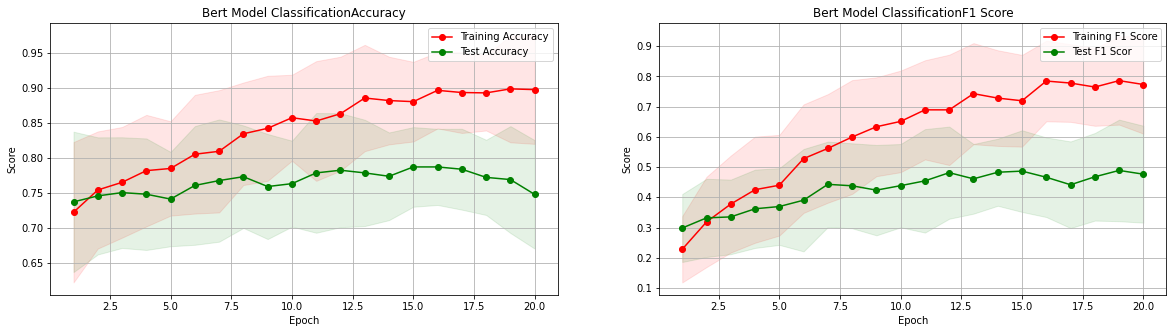

In [145]:
import torch.nn as nn
import torch.optim as optim

loss_function = nn.CrossEntropyLoss()
optimizer = optim.AdamW(bertGRUmodel.parameters(), lr = 0.001)
n_epochs = 20

loss_function.to(device)
bertGRUmodel = bertGRUmodel.to(device)

train_loop(bertGRUmodel, optimizer, loss_function, train_loader, test_loader, max_eps= n_epochs, print_every=100, gpu=(device.type == 'cuda'))

==>Epoch: 01 | Epoch Time: 0m 20s
	 Train Loss: 0.586 | Train Acc: 80.41% | Train f1 score: 69.67%
	 Test  Loss: 0.556 | Test  Acc: 80.33% | Test  f1 score: 73.86%
==>Epoch: 02 | Epoch Time: 0m 20s
	 Train Loss: 0.418 | Train Acc: 86.61% | Train f1 score: 79.23%
	 Test  Loss: 0.447 | Test  Acc: 84.24% | Test  f1 score: 79.87%
==>Epoch: 03 | Epoch Time: 0m 20s
	 Train Loss: 0.361 | Train Acc: 87.26% | Train f1 score: 81.46%
	 Test  Loss: 0.375 | Test  Acc: 88.54% | Test  f1 score: 85.87%
==>Epoch: 04 | Epoch Time: 0m 20s
	 Train Loss: 0.287 | Train Acc: 90.51% | Train f1 score: 86.59%
	 Test  Loss: 0.359 | Test  Acc: 88.13% | Test  f1 score: 87.77%
==>Epoch: 05 | Epoch Time: 0m 20s
	 Train Loss: 0.264 | Train Acc: 90.73% | Train f1 score: 87.78%
	 Test  Loss: 0.316 | Test  Acc: 90.49% | Test  f1 score: 88.75%
==>Epoch: 06 | Epoch Time: 0m 20s
	 Train Loss: 0.254 | Train Acc: 91.38% | Train f1 score: 87.95%
	 Test  Loss: 0.318 | Test  Acc: 89.44% | Test  f1 score: 86.84%
==>Epoch: 07 | E

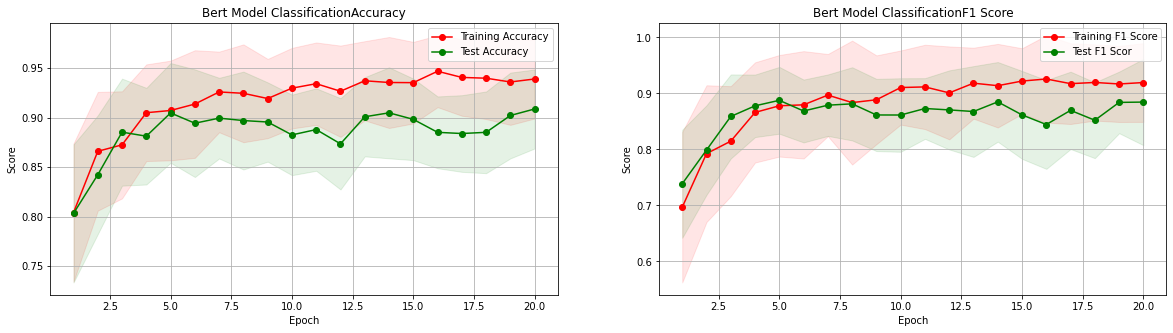

In [146]:
train_loop(bertGRUmodel, optimizer, loss_function, train_loader_ROS, test_loader_ROS, max_eps= n_epochs, print_every=100, gpu=(device.type == 'cuda'))